# Gene expression & surface protein TIL 

## Load adata annotated 

In [1]:
# Libraries
import anndata as ad
import matplotlib as plt
import numpy as np
import pandas as pd
import sc_atlas_helpers as ah
import scanpy as sc
from matplotlib.pyplot import rc_context
from scipy.stats import median_abs_deviation

In [2]:
from functools import partial

import altair as alt

In [3]:
import seaborn as sns

In [4]:
import decoupler as dc

In [5]:
resDir = "/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/40_gex_surface_prot/"
inputDir = "/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/40_gex_surface_prot/"

In [6]:
adata = sc.read_h5ad(f"{resDir}adata_merged_til_annotated.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 47016 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells'
    uns: 'cell_type_colors', 'joint_leiden_colors', 'sample_id_colors'
    obsm: 'X_pca', 'X_umap', 'protein', 'protein_umap'
    layers: 'counts'

In [8]:
adata

AnnData object with n_obs × n_vars = 47016 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells'
    uns: 'cell_type_colors', 'joint_leiden_colors', 'sample_id_colors'
    obsm: 'X_pca', 'X_umap', 'protein', 'protein_umap'
    layers: 'counts'

In [9]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))


In [10]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 47016 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'joint_leiden_colors', 'sample_id_colors'
    obsm: 'X_pca', 'X_umap', 'p

In [ ]:
sc.pl.violin(adata, "pct_counts_mt")

In [12]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [13]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    46282
True       734
Name: outlier, dtype: int64

In [14]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 1.5
)
adata.obs.mt_outlier.value_counts()

False    40955
True      6061
Name: mt_outlier, dtype: int64

In [15]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 47016
Number of cells after filtering of low quality cells: 40851


In [ ]:
sc.pl.violin(adata, "pct_counts_mt")

In [ ]:
# Visualize
sc.pl.umap(adata, color='joint_leiden')

In [18]:
#sc.pl.umap(adata, color = ["Cd69","Il2ra"], cmap="Reds", vmax="p99")

In [19]:
#sc.pl.violin(adata, keys = ["Cd69","Il2ra"], groupby="joint_leiden")

In [20]:
#markers =["Cd69","Il2ra"]
#sc.pl.dotplot(adata,markers , groupby='joint_leiden', dendrogram=False,log=True, cmap="seismic" )

In [21]:
#sc.pl.umap(adata, color = ["Sell","Cd44"], cmap="Reds", vmax="p99")

In [22]:
#markers =["Sell","Cd44"]
#sc.pl.dotplot(adata,markers , groupby='joint_leiden', dendrogram=False,log=True, cmap="seismic" )

In [23]:
#sc.pl.violin(adata, keys = ["Sell","Cd44"], groupby="joint_leiden")

In [24]:
#sc.pl.umap(adata, color = ["Gzmk","Il7r"], cmap="Reds", vmax="p99")

In [25]:
#sc.pl.umap(adata, color = ["Sell","Cd69","Il2ra"], cmap="Reds", vmax="p99")

In [26]:
adata.obs.sample_id.value_counts()

10mix_ICI1      6442
11mix_ICI1      6204
GF_ICI2_plus    5575
11mix_ICI2      5315
GF_ICI1         4874
GF_ICI1_plus    4515
10mix_ICI2      4379
GF_ICI2         3547
Name: sample_id, dtype: int64

In [27]:
adata

AnnData object with n_obs × n_vars = 40851 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'joint_leiden_colors', 'sample_id_colors'
    ob

In [28]:
adata_til1 = adata[adata.obs["joint_leiden"].isin(["3","4"])]

In [29]:
adata_til2 = adata[adata.obs["joint_leiden"].isin(["0","1","2","5","6"])]

In [30]:
adata_til2.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

/tmp/ipykernel_2202755/3524352919.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_til2.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))


In [31]:
adata_til1.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

/tmp/ipykernel_2202755/65121397.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_til1.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))


In [32]:
adata_til1 = adata_til1[:, adata_til1.var['ribo'] == False].copy()

In [33]:
adata_til2 = adata_til2[:, adata_til2.var['ribo'] == False].copy()

In [34]:
sc.pp.neighbors(adata_til1, n_neighbors=10)
sc.tl.leiden(adata_til1, resolution=0.32, n_iterations=-1)
sc.tl.umap(adata_til1)

/tmp/ipykernel_2202755/2252530170.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_til1, resolution=0.32, n_iterations=-1)


In [ ]:
sc.pl.umap(adata_til1, color = "leiden")

In [36]:
annotation_dict = {
    '2':'MPEC2',
    '0':'MPEC1',
    '1':'MPEC3',}

In [37]:
#sc.pl.umap(adata_til1, color = ["Sell","Cd44"], cmap="Reds", vmax="p99")

In [38]:
#markers =["Sell","Cd44"]
#sc.pl.dotplot(adata_til1,markers , groupby='leiden', dendrogram=False,log=True, cmap="seismic" )

In [39]:
#sc.pl.violin(adata_til1, keys = ["Sell","Cd44"], groupby="cell_type", rotation=45)

In [40]:
#sc.pl.violin(adata_til1, keys = ["Itga4"], groupby="cell_type", rotation=45)

In [41]:
#sc.pl.umap(adata_til1, color = ["Itga4"], cmap="Reds", vmax="p99")

In [42]:
#sc.pl.umap(adata, color = ["Itga4","joint_leiden"], cmap="Reds", vmax="p99")

In [43]:
#markers =["Itga4"]
#sc.pl.dotplot(adata,markers , groupby='joint_leiden', swap_axes =False,log=True, cmap="seismic" )

## Tumor reactive like CD8 T cell markers
# Lacking Layn 
https://ars.els-cdn.com/content/image/1-s2.0-S1535610824002344-gr4_lrg.jpg

In [44]:
#sc.pl.umap(adata_til1, color = ["Cxcr5","Gzmk","Il7r"], cmap="Reds", vmax="p99")

In [45]:
#markers =["Cxcr5","Gzmk","Il7r"]
#sc.pl.dotplot(adata_til1,markers , groupby='joint_leiden', swap_axes =False,log=True, cmap="seismic" )

## Cycling marker

In [46]:
#sc.pl.umap(adata_til1, color = ["Mki67"], cmap="Reds", vmax="p99")

## T differentiation 

In [47]:
#sc.pl.umap(adata_til1, color = ["Sell","Cd44"], cmap="Reds", vmax="p99")

## Surface antibodies

In [48]:
#sc.pl.umap(adata_til1, color = ["PD1_TotalSeqC","CD69_TotalSeqC","CD44_TotalSeqC","ICOS_TotalSeqC","CD103_TotalSeqC"], cmap="Reds", vmax="p99")

## T effector into SLEC and MPEC

In [49]:
#sc.pl.umap(adata_til1, color = ["Klrg1","Il7r","Tbx21"], cmap="Reds", vmax="p99")

In [50]:
#sc.pl.violin(adata_til1, keys =["Klrg1","Il7r","Tbx21"], groupby="cell_type", rotation=45)

In [51]:
#markers =["Klrg1","Il7r","Tbx21"]
#sc.pl.dotplot(adata_til1,markers , groupby='cell_type', swap_axes =False,log=True, cmap="seismic" )

## Markers from publication SLECs & MPECs 
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2034442/

- MPECs KLRG1 low, Il7r high, CD122 high, SELF RENEWAL
- SLECs KLRG1 high, Il7r low, Cd122 high NOT SELF RENEWAl

- Naive CD8 T cells are IL-7Rhi, CD122lo (IL-2/15βR), KLRG1neg and T-betneg and are IL-7 dependent. Early during infection, most effector CD8 T cells become CD122hi and downregulate IL-7R to an intermediate-to-low level, but expression of T-bet and KLRG1 is set depending on their exposure to inflammatory cytokines (e.g. IL-12). Effector CD8 T cells that are exposed to lower levels of inflammation express less T-bet (light blue cells) and begin to upregulate IL-7R to become KLRG1lo IL-7Rhi MPECs (turquoise cells). Effector CD8 T cells that encounter higher levels of inflammatory cytokines express relatively more T-bet and KLRG1 (dark blue cells), stably repress IL-7R and consequentially become KLRG1hi IL-7Rlo SLECs. SLECs become IL-15 dependent, however, IL-15 alone cannot support their long-term persistence or homeostatic turnover and they decline over time. In contrast, MPECs remain dually responsive to IL-7 and IL-15 and preferentially develop into long-lived memory CD8 T cells that can self-renew.

In [52]:
#sc.pl.umap(adata_til1, color = ["Klrg1","Il7r","Il2rb","Itga4","Itgae","Cxcr3","Casp3"], cmap="Reds", vmax="p99")

In [53]:
#sc.pl.umap(adata_til1, color = ["Cxcr3","Casp3"], cmap="Reds", vmax="p99")

In [54]:
#sc.pl.violin(adata_til1, keys = ["Cxcr3","Casp3"], groupby="cell_type", rotation=45)

In [55]:
#markers =["Cxcr3","Casp3","Gzmb","Gzmk","Gzma","Ifng","Tox","Lag3"]
#sc.pl.dotplot(adata_til1,markers , groupby='cell_type', swap_axes =False,log=True, cmap="seismic" )

In [56]:
#sc.pl.umap(adata_til1, color = ["Cxcr5"], cmap="Reds", vmax="p99")

## CYTOTOXIC 

In [57]:
#sc.pl.umap(adata_til1, color = ["Gzmb","Gzmk","Gzma","Ifng"], cmap="Reds", vmax="p99")

In [58]:
#sc.pl.violin(adata_til1, keys =["Gzmb","Gzmk","Gzma","Ifng"], groupby="cell_type", rotation=45)

## T act EARLY vs LATE 
CD25 --> Il2ra

In [59]:
#sc.pl.umap(adata_til1, color = ["Cd69","Il2ra"], cmap="Reds", vmax="p99")

## Top genes from rank genes 

In [60]:
adata_til1.obs.leiden

AAACCTGAGGCTCTTA-1_10mix_ICI1      0
AAACCTGAGGGCTTGA-1_10mix_ICI1      2
AAACGGGAGCTAGGCA-1_10mix_ICI1      1
AAACGGGCAAACGCGA-1_10mix_ICI1      2
AAACGGGCAATTCCTT-1_10mix_ICI1      0
                                  ..
TTTGGTTCAATTGCTG-1_GF_ICI2_plus    2
TTTGGTTCAGGCGATA-1_GF_ICI2_plus    1
TTTGGTTGTCTCTTTA-1_GF_ICI2_plus    2
TTTGTCACACGGCTAC-1_GF_ICI2_plus    1
TTTGTCACAGCTCCGA-1_GF_ICI2_plus    0
Name: leiden, Length: 8911, dtype: category
Categories (3, object): ['0', '1', '2']

In [61]:
#sc.tl.rank_genes_groups(adata_til1, "leiden", method="t-test")
#sc.pl.rank_genes_groups(adata_til1, n_genes=25, sharey=False)

In [62]:
#pd.DataFrame(adata_til1.uns["rank_genes_groups"]["names"]).head(20)

In [63]:
#sc.pl.umap(adata_til1, color = ["ICOS_TotalSeqC","CD103_TotalSeqC","Lef1","Ccr7","Ly6c2","CD44_TotalSeqC","Eef1b2","Sell","Ccl5","S100a6","Nkg7","Itgb1"], cmap="Reds", vmax="p99")

## Cluster mpec1 naive 

In [64]:
#sc.pl.umap(adata_til1, color = ["ICOS_TotalSeqC","CD103_TotalSeqC","Lef1","Ccr7","Satb1","Klf2"], cmap="Reds", vmax="p99")

## Cluster mpec memory  

In [65]:
#sc.pl.umap(adata_til1, color = ["Ly6c2","CD44_TotalSeqC","Bcl2","Eef1b2","Nme2","Sell"], cmap="Reds", vmax="p99")

## Cluster 2 effector

In [66]:

#sc.pl.umap(adata_til1, color = ["Ccl5","Nkg7","S100a6","Lgals1","H2-D1"], cmap="Reds", vmax="p99")

## Exhaustion markers

In [67]:
#sc.pl.umap(adata_til1, color = ["Tox","Lag3"], cmap="Reds", vmax="p99")

In [68]:
#sc.pl.violin(adata_til1, keys =["Tox","Lag3"], groupby="cell_type", rotation=45)

In [69]:
#sc.pl.umap(adata_til1, color = ["CD103_TotalSeqC","Bcl2","Cxcr3"], cmap="Reds", vmax="p99")

In [ ]:
## Add cell type column based on annotation
adata_til1.obs['cell_type'] = [annotation_dict[clust] for clust in adata_til1.obs['leiden']]

# Visualize
sc.pl.umap(adata_til1, color='cell_type')

# Adata til2

In [71]:
sc.pp.neighbors(adata_til2, n_neighbors=10)
sc.tl.leiden(adata_til2, resolution=0.5,  n_iterations=-1)
sc.tl.umap(adata_til2)

In [ ]:
sc.pl.umap(adata_til2, color = "leiden")

In [73]:
#sc.pl.umap(adata_til2, color = ["PD1_TotalSeqC","CD69_TotalSeqC","CD44_TotalSeqC","ICOS_TotalSeqC","CD103_TotalSeqC"], cmap="Reds", vmax="p99")

In [74]:
#sc.pl.umap(adata_til2, color = ["PD1_TotalSeqC","Lag3","Tox","Havcr2","Entpd1"], cmap="Reds", vmax="p99")

In [75]:
#sc.pl.umap(adata_til2, color = ["CD69_TotalSeqC","CD103_TotalSeqC","Itgae","Sell","CD44_TotalSeqC","Cd44"], cmap="Reds", vmax="p99")

## CYTOTOXIC 

In [76]:
#sc.pl.umap(adata_til2, color = ["Gzmb","Gzmk","Gzma","Ifng"], cmap="Reds", vmax="p99")

## JUST A CHECK

### Early vs late 

In [77]:
#sc.pl.umap(adata_til2, color = ["Cd69","Il2ra"], cmap="Reds", vmax="p99")

### Differentiation

In [78]:
#sc.pl.umap(adata_til2, color = ["Sell","Cd44"], cmap="Reds", vmax="p99")

### Effector states

In [79]:
#sc.pl.umap(adata_til2, color = ["Klrg1","Il7r"], cmap="Reds", vmax="p99")

In [80]:
#sc.tl.rank_genes_groups(adata_til2, "leiden", method="t-test")
#sc.pl.rank_genes_groups(adata_til2, n_genes=25, sharey=False)

In [81]:
#pd.DataFrame(adata_til2.uns["rank_genes_groups"]["names"]).head(20)

In [82]:
#sc.tl.rank_genes_groups(adata_til2, 'leiden')

In [83]:
#sc.pl.rank_genes_groups_dotplot(
#    adata_til2,
#    n_genes=4,
#    values_to_plot="logfoldchanges", cmap='Reds',
#    vmin=-4,
#    vmax=4,
#    min_logfoldchange=3,
#    colorbar_title='log fold change'
#)

In [ ]:
sc.pl.umap(adata_til2, color = "leiden")

In [85]:
#markers =["Lag3","Tox","Ifit1","Ifitm1","Ifit3","Ccl5","Ccr7","Sell","Foxp1","Dock2","Dock10","Zc3h7a","S100a6","Gzmb","Il31ra","Lef1"]
#sc.pl.dotplot(adata_til2, markers, groupby='rna_leiden', dendrogram=True,log=True, cmap="Reds" )

In [86]:
#annotation_dict = {
#   '0':'SLEC_Ccr7',
#   '1':'SLEC_unknown',
#   '2':'SLEC_Ifit3',
#   '3':'SLEC_Dock2',
#   '4':'SLEC_Ccr7',
#   '5':'SLEC_unknown',
#   '6':'SLEC_Ccr7',
#   '7':'SLEC_Ifitm1',
#   '8':'SLEC_Trbv13-2',
#   '9':'SLEC_Trbv16',
#   '10':'SLEC_unknown',
#   '11':'SLEC_Hmgb2',
#   '12':'SLEC_Zc3h7a',
#   '13':'SLEC_Dock2',
#   '14':'SLEC_Zc3h7a'}

In [87]:
## Add cell type column based on annotation
#adata_til2.obs['cell_type'] = [annotation_dict[clust] for clust in adata_til2.obs['rna_leiden']]

# Visualize
#sc.pl.umap(adata_til2, color='cell_type')

In [88]:
#sc.pl.umap(adata_til2, color='leiden')

In [89]:
#sc.pl.umap(adata_til2, color='rna_leiden')

In [90]:
#sc.tl.rank_genes_groups(adata_til2, 'rna_leiden')

In [91]:
#pd.DataFrame(adata_til2.uns["rank_genes_groups"]["names"]).head(20)

In [92]:
#sc.pl.rank_genes_groups_dotplot(
#    adata_til2,
#    n_genes=4,
#    values_to_plot="logfoldchanges", cmap='Reds',
#    vmin=-4,
#    vmax=4,
#    min_logfoldchange=3,
#    colorbar_title='log fold change'
#)

In [93]:
#sc.pl.umap(adata_til2, color = ["Ifit3","Ifit1","Ifitm1","Sell","Tnfrsf9","Ccr7","Trbv13-2","Trbv16","Stmn1","Hmgb2","Zc3h7a","Tox","Dock2","Itga4","Cxcr3","Itgae","Il2rb"], cmap="Reds", vmax="p99", legend_loc="on data")

In [94]:
#sc.pl.umap(adata_til2, color = "rna_leiden",vmax="p99", cmap="Reds")

## Markers of exhausted CD8+ T cell subsets 

- https://pubmed.ncbi.nlm.nih.gov/36907685/#&gid=article-figures&pid=figure-1-uid-0

Tex_pro : Ly1008+, Cxcr5+ Il7r+, Cd62l+, Ccr7+ ,Ifng low, Tnf alpha low, Tcf1+, Tox high, Eomes int  

- Ly108 - Slamf6
- Tcf1  - Tcf7
- Cd62 - Sell 

Tex_int: Cxcr1+, Cxcr6 high, Tim3+, PD1int, Gzmb int, Ifng int, Tnfa int, Tox int, Eomes int, Tbet int, NR4aw int

- "Cxcr1" - Il8ra no present
- Tim3 - Havcr2

Tex eff Cxcr1+, Klrg1+, Cxcr6+, Tim3+, Pd1int, Gzmb high, Ifng high, Tnf a high, Tbet high, Zeb2+, 

Tex term Tim3+, Pd1 high, Lag3 high, Cxcr6 high, Cd101+, Gzmbint, Gzmk+, Ifng low, Tnfa low, Tox high, Eomes high, Nr4a2+ 

## Tex_prog

In [95]:
#Tex_prog = ["Slamf6","Cxcr5","Il7r","Sell","Ccr7","Ifng","Tnf","Tcf7","Tox","Eomes"]

In [96]:
#sc.pl.umap(adata_til2, color = Tex_prog, cmap="Reds", vmax="p99")

## Tex_int

In [97]:
#Tex_int = ["Cxcr6","Havcr2","Pdcd1","Gzmb","Ifng","Tnf","Tox","Eomes","Nr4a2"]

In [98]:
#sc.pl.umap(adata_til2, color = Tex_int, cmap="Reds", vmax="p99")

## Tex_eff

In [99]:
#Tex_eff = ["Klrg1","Cxcr6","Havcr2","Pdcd1","Gzmb","Ifng","Tnf","Zeb2"]

In [100]:
#sc.pl.umap(adata_til2, color = Tex_eff, cmap="Reds", vmax="p99")

## Tex_term

In [101]:
#Tex_term = ["Havcr2","Pdcd1","Lag3","Cxcr6","Cd101","Gzmb","Gzmk","Ifng","Tnf","Tox","Eomes", "Nr4a2"]

In [102]:
#sc.pl.umap(adata_til2, color = Tex_term, cmap="Reds", vmax="p99")

## All markers for of exhausted CD8+ T cell subsets

In [103]:
#markers = Tex_prog + Tex_eff + Tex_int + Tex_term

In [104]:
#markers_unique = list(set(markers))

In [105]:
#markers_unique.append("Klrg1")

## SLEC 

In [106]:
#sc.pl.dotplot(adata_til2, markers_unique, groupby='leiden', dendrogram=True)

In [107]:
#sc.pl.umap(adata_til1, color='cell_type')

In [108]:
#sc.pl.umap(adata_til2, color = ["leiden","rna_leiden"])

In [109]:
#sc.pl.umap(adata_til2, color = ["rna_leiden"], groups=["3","4","6","12"])

In [110]:
#Texprog = ["Slamf6","Sell","Ccr7","Tcf7"]
#Texint = ["Havcr2","Entpd1","Gzmb","Tox","Ifng","Tnf","Tox","Eomes","Tbx21","Nr4a2"]
#Texeff = ["Klrg1","Cxcr6","Havcr2","Entpd1","Gzmb","Ifng","Zeb2"]
#Texeterm = ["Havcr2","Entpd1","Lag3","Cxcr6","Cd101","Gzmb","Gzmk","Ifng","Tnf","Tox","Eomes","Nr4a2"]

In [111]:
#sc.pl.umap(adata_til2, color = Texprog, cmap="Reds", vmax="p99", vmin=0)

In [112]:
#sc.pl.umap(adata_til2, color = Texint, cmap="Reds",  vmax="p99", vmin=0)

In [113]:
#sc.pl.umap(adata_til2, color = Texeff, cmap="Reds",  vmax="p99", vmin=0)

In [114]:
#sc.pl.umap(adata_til2, color = Texeterm, cmap="Reds",  vmax="p99", vmin=0)

In [115]:
#sc.pl.umap(adata_til2, color = ["Sell","Ccr7","Cxcr3","Trbv16","Trbv13-2","Hmgb2","Gzmb","Ifit3","Ifit1","Ifitm1","Zc3h7a","Tox"], cmap="Reds",  vmax="p99", vmin=0)

In [116]:
annotation_dict = {
    '0':'Tex_eff',
    '1':'Tex_eff',
    '2':'Interferon_response',
    '3':'Tex_term',
    '4':'Plastic',
    '5':'Tex_eff',
    '6':'Tex_prog',
    '7':'Interferon_response',
    '8':'Tex_int',
    '9':'Tex_int',
    '10':'Tex_term',
    '11':'Tex_int',
    '12':'Tex_term',
    '13':'Tex_term',
    '14':'Tex_term'}

In [ ]:
## Add cell type column based on annotation
adata_til2.obs['cell_type'] = [annotation_dict[clust] for clust in adata_til2.obs['rna_leiden']]

# Visualize
sc.pl.umap(adata_til2, color='cell_type')

In [118]:
#sc.pl.umap(adata_til2, color='rna_leiden')

In [119]:
#adata.write_h5ad(f"{resDir}/adata_merged_til_annotated.h5ad")

## Checking subsets from publication 
https://www.sciencedirect.com/science/article/pii/S1535610824002344?ref=pdf_download&fr=RR-2&rr=8a7ba8113b45c268


In [120]:
#markers_tcell_subset = ["Ccr7","Sell","Anxa1","Gzmk","Xcl1","Hspa1b","Cx3cr1","Cd160"]

In [121]:
#sc.pl.umap(adata, color = markers_tcell_subset, cmap="Reds",  vmax="p99", vmin=0)

In [122]:
#sc.pl.umap(adata_til1, color = markers_tcell_subset, cmap="Reds",  vmax="p99", vmin=0)

In [123]:
#sc.pl.umap(adata_til2, color = markers_tcell_subset, cmap="Reds",  vmax="p99", vmin=0)

In [124]:
## SLEC vs MPEC difference 

In [125]:
#sc.pl.umap(adata, color = ["Klrg1","Il7r","Tbx21"], cmap="Reds",  vmax="p99", vmin=0)

In [126]:
#adata

In [127]:
#sc.pl.violin(adata, keys = ["Klrg1","Il7r","Tbx21"], groupby="joint_leiden")

In [128]:
#markers =["Klrg1","Il7r","Tbx21"]
#sc.pl.dotplot(adata, markers, groupby='joint_leiden', dendrogram=False,log=True, cmap="seismic" )

In [129]:
#sc.pl.matrixplot(adata, markers, groupby='joint_leiden', dendrogram=True,log=True)

In [130]:
#sc.pl.umap(adata, color = "joint_leiden")

In [131]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("str")
adata.obs.loc[adata_til2.obs.index, "cell_type"] = adata_til2.obs["cell_type"].astype("str")

In [132]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("str")
adata.obs.loc[adata_til1.obs.index, "cell_type"] = adata_til1.obs["cell_type"].astype("str")

In [ ]:
sc.pl.umap(adata, color='cell_type')#, legend_loc="on data",legend_fontsize=5)

In [134]:
adata.obs["cell_type2"] = adata.obs["cell_type"] 

In [135]:
set(adata.obs["cell_type2"])

{'Interferon_response',
 'MPEC1',
 'MPEC2',
 'MPEC3',
 'Plastic',
 'Tex_eff',
 'Tex_int',
 'Tex_prog',
 'Tex_term'}

In [136]:
set(adata.obs["cell_type"])

{'Interferon_response',
 'MPEC1',
 'MPEC2',
 'MPEC3',
 'Plastic',
 'Tex_eff',
 'Tex_int',
 'Tex_prog',
 'Tex_term'}

In [137]:
adata.obs["cell_type2"].replace('Plastic', 'SLEC1', inplace=True)
adata.obs["cell_type2"].replace('Tex_prog', 'SLEC2', inplace=True)
adata.obs["cell_type2"].replace('Tex_int', 'SLEC3', inplace=True)
adata.obs["cell_type2"].replace('Interferon_response', 'SLEC4', inplace=True)
adata.obs["cell_type2"].replace('Tex_eff', 'SLEC5', inplace=True) 
adata.obs["cell_type2"].replace('Tex_term', 'SLEC6', inplace=True)
adata.obs["cell_type2"].replace('Zc3h7a', 'SLEC6', inplace=True)


In [ ]:
sc.pl.umap(adata, color=['cell_type2','cell_type'], sort_order=True)

In [139]:
adata

AnnData object with n_obs × n_vars = 40851 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'joint_leiden_colors', 'sample_id_

In [140]:
#adata.write_h5ad("/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/adata_merged_til_slec_mpec_annotation_tryneighbors.h5ad", )

## PAGA

In [141]:
# Libraries
import anndata as ad
import matplotlib as plt
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
#import sc_atlas_helpers as ah
import scanpy as sc
from matplotlib.pyplot import rc_context
from scipy.stats import median_abs_deviation
from scipy.stats import mode
from collections import Counter

In [142]:
sc.pp.neighbors(adata, n_neighbors=7, n_pcs=20)

In [143]:
sc.tl.leiden(adata)

In [144]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden','louvain'], sort_order=True)

In [146]:
adata

AnnData object with n_obs × n_vars = 40851 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2', 'leiden', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'joint_leiden

In [147]:
#adata.write_h5ad("adata_neighbors.h5ad")

In [148]:
adata = sc.read_h5ad("adata_neighbors.h5ad")

In [149]:
sc.tl.paga(adata)

In [150]:
#sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden','louvain'], sort_order=True)

In [ ]:
sc.pl.umap(adata, color=['cell_type','cell_type2'], sort_order=True)

In [153]:
sc.tl.diffmap(adata)

In [154]:

sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

In [155]:
#adata.obs['cell_type2'].cat.categories = [str(i) for i in range(len(adata.obs['cell_type2'].cat.categories))]

In [169]:
adata.obs['clusters'] = adata.obs['cell_type']

In [170]:
sc.tl.paga(adata, groups='clusters')

In [ ]:
sc.pl.paga(adata, threshold=0.02, edge_width_scale=1, layout='fr', random_state=0)

In [172]:
pos = adata.uns['paga']['pos']

In [ ]:
sc.pl.paga(adata, threshold=0.02, edge_width_scale=1, layout='fr', pos=pos)

In [174]:
#sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.pl.umap(adata, color='clusters', legend_loc='on data')

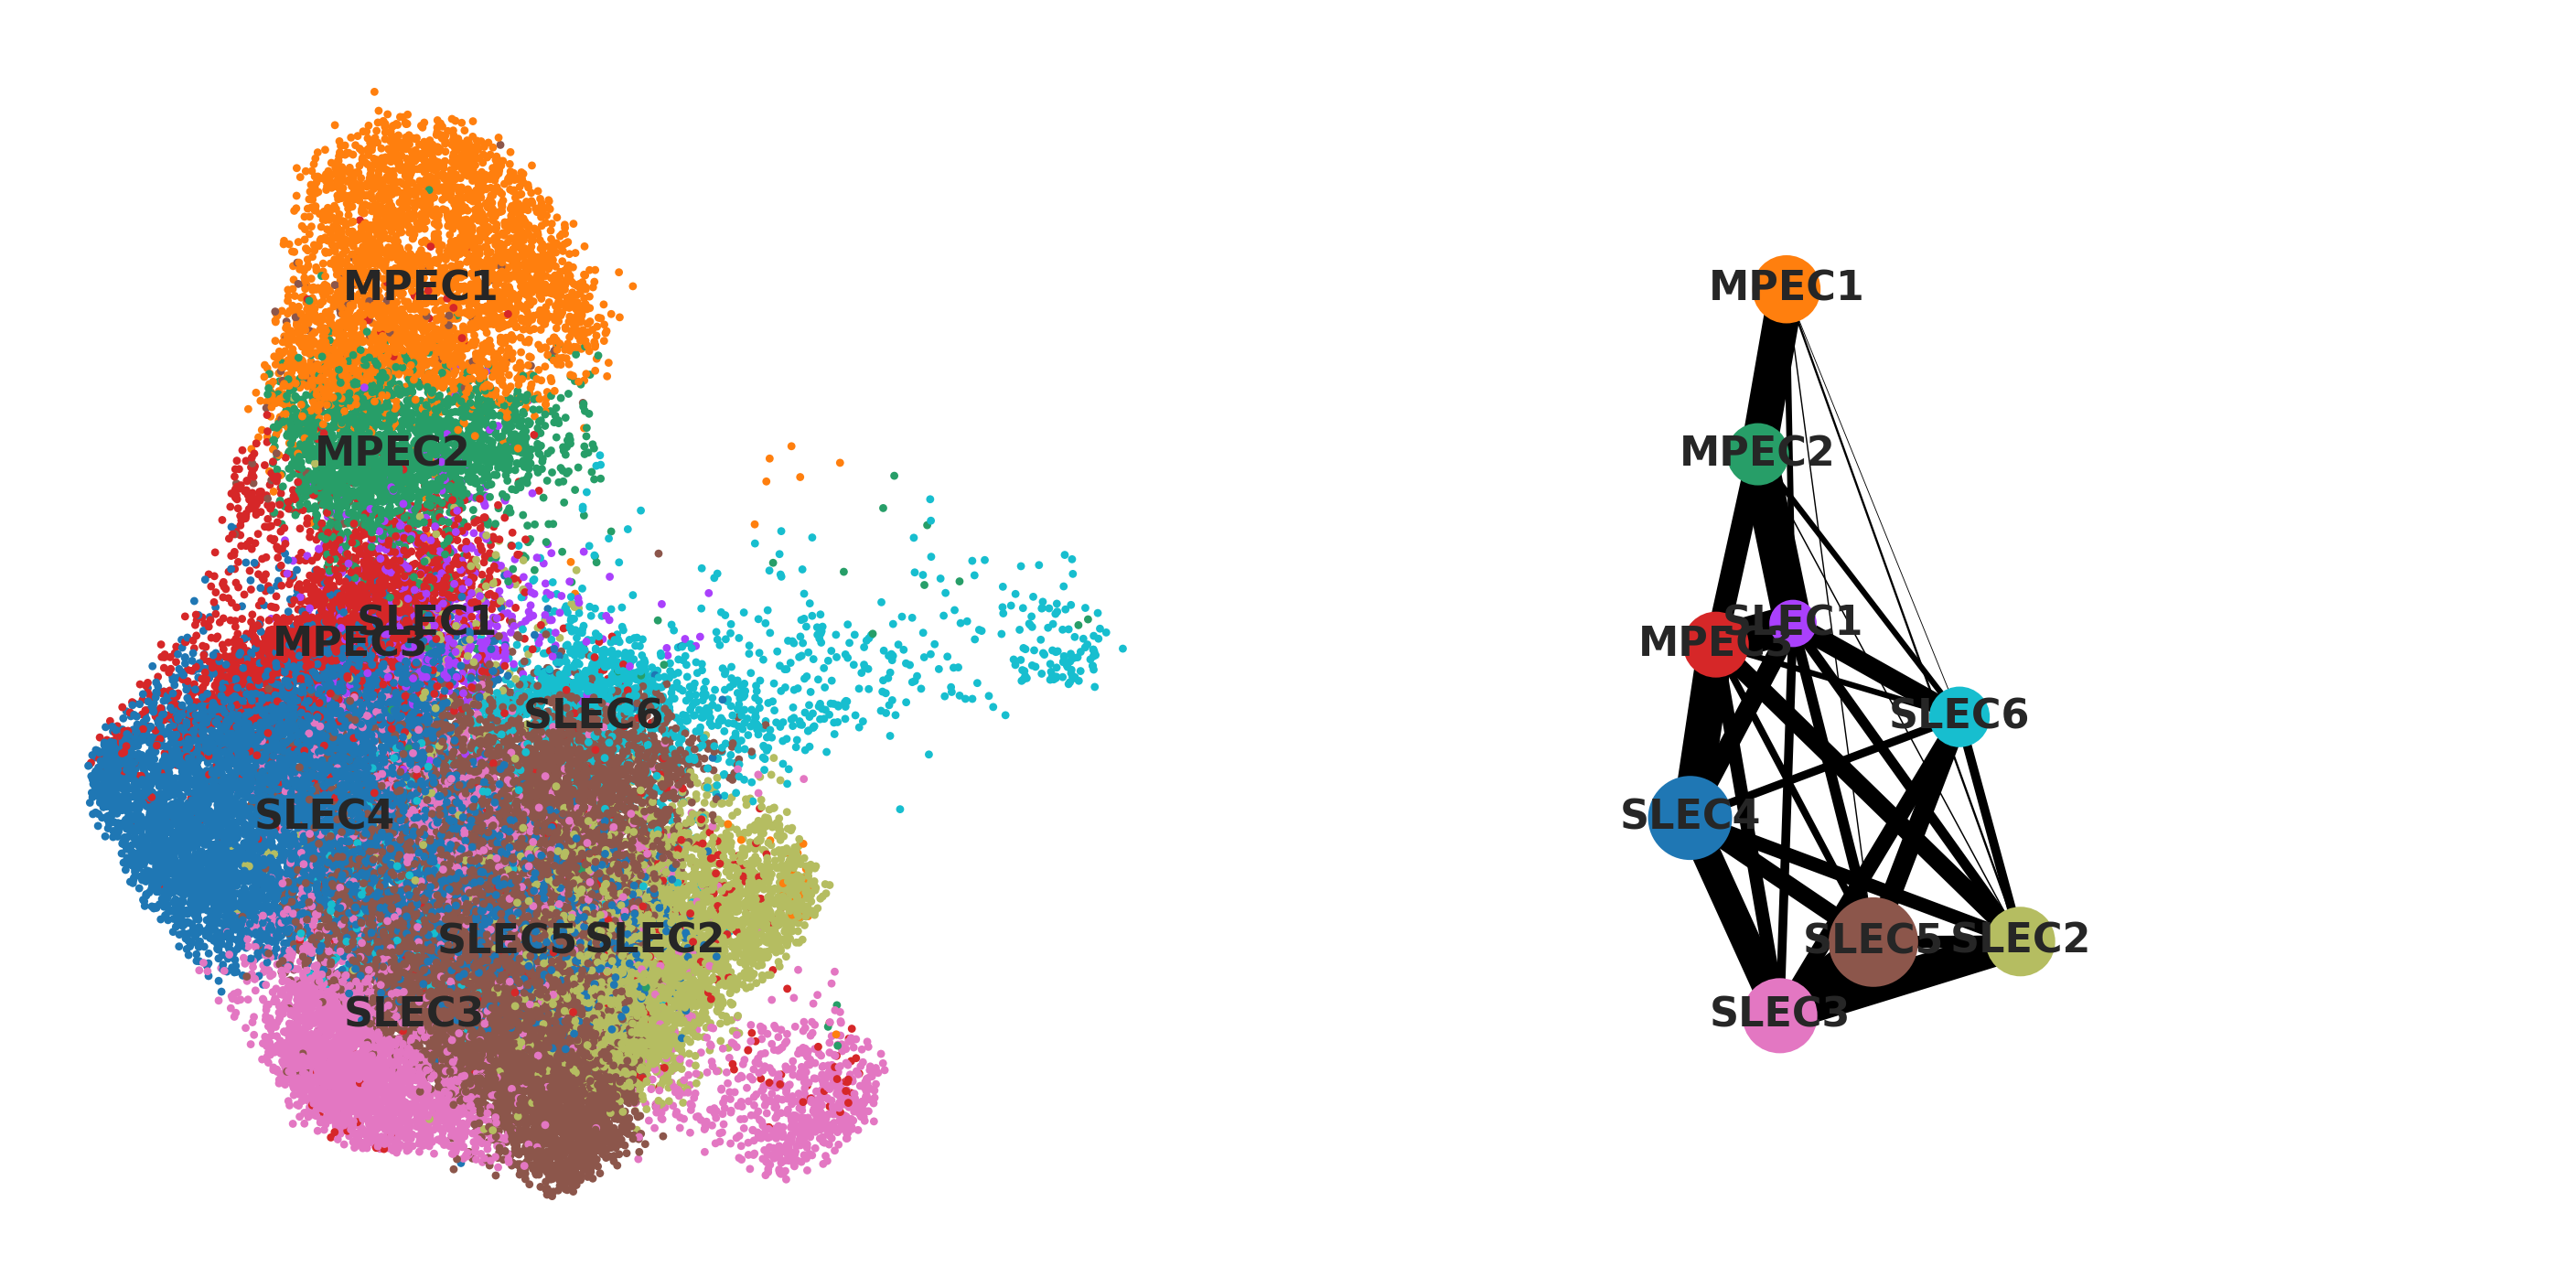

In [163]:
axs = sc.pl.paga_compare(
    adata, title='', right_margin=0.2, size=10,
    threshold=0.02,
    legend_fontsize=8, fontsize=8, frameon=False, show=False)

In [164]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['clusters'] == 'MPEC1')[0]

In [165]:
sc.tl.dpt(adata)

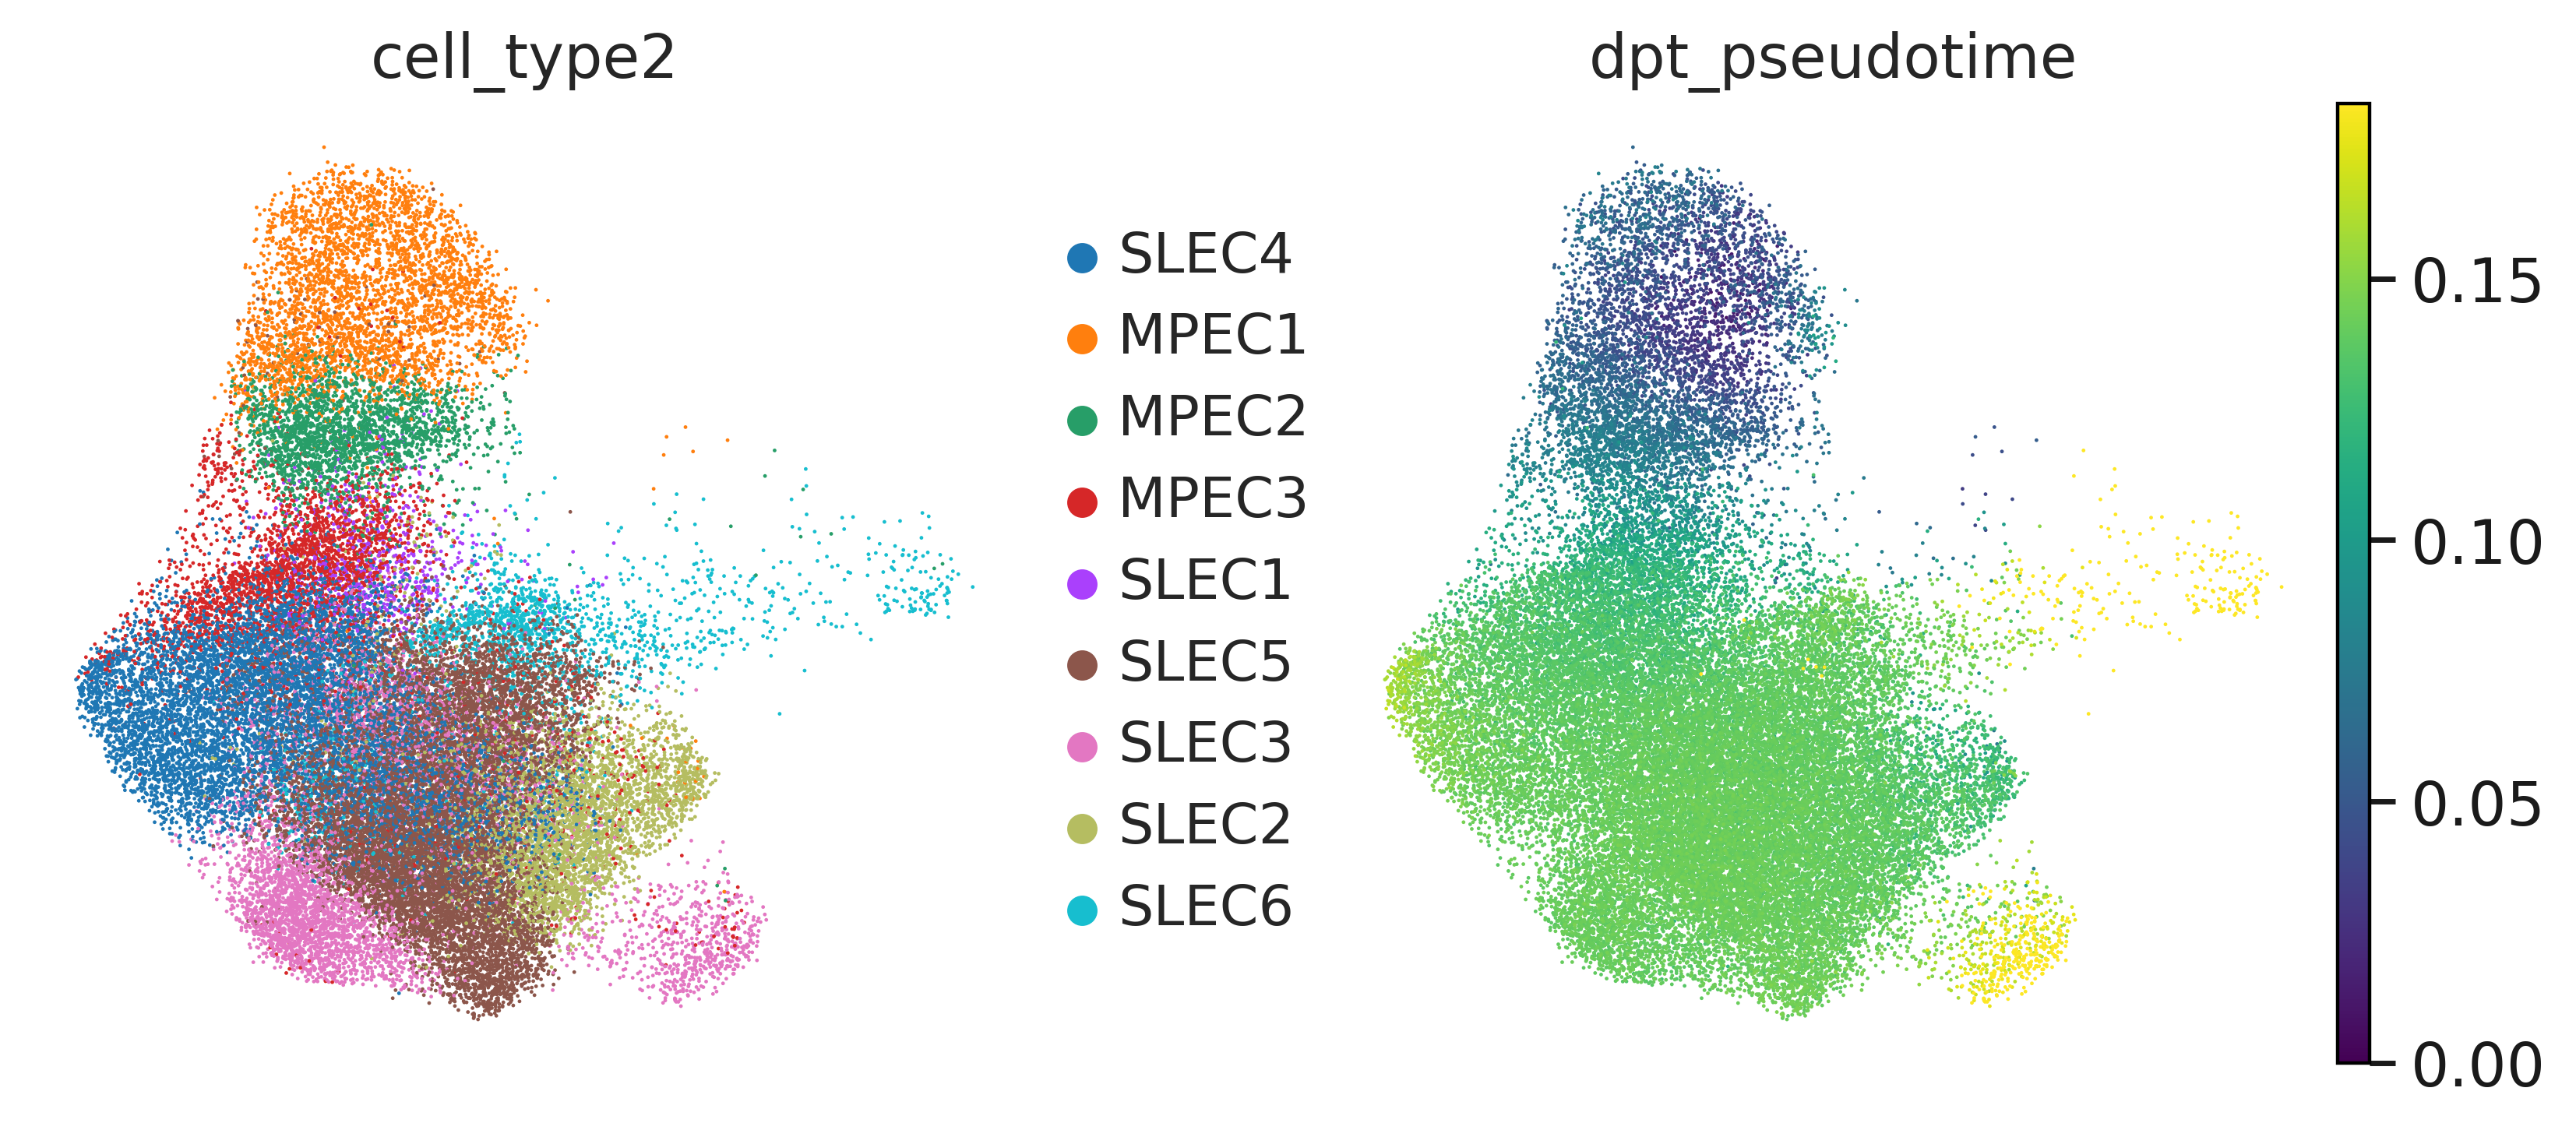

In [166]:
sc.pl.umap(adata, color=['cell_type2','dpt_pseudotime'], vmax="p99", cmap = "viridis")